In [1]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("2.0A"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

original dir:  e:\SUSTech-Battery\data_our_refined\2.0A
changed dir:  e:\SUSTech-Battery\data_our_refined


In [2]:
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from battery_predictor import BatteryPredictor
from battery_dataset import BatteryDataset

cpu


In [3]:
curves1, labels1 = utils.read_data(capacity_file='./2.0A/1/capacity.xlsx', curve_file='./2.0A/1/curve.xlsx')
# curves2, labels2 = utils.read_data(capacity_file='./2.0A/2/capacity.xlsx', curve_file='./2.0A/2/curve.xlsx')
# curves3, labels3 = utils.read_data(capacity_file="./2.0A/3/capacity.xlsx", curve_file="./2.0A/3/curve.xlsx")


Total 858 curves, Total 858 labels
The first curve has 237 data points and 5 stages


In [4]:
CURVES = curves1
LABELS = labels1

In [5]:
delta_t = 30 # s

Vh = 4.2  # V
Vl = 4.0  # V

Ih = 3.0  # A
Il = 0.5  # A

NUM_V = 20
NUM_I = 10

In [6]:
BATCH_SIZE = 16
EPOCHS = 50

In [7]:
from torch.utils.data import DataLoader


data_X_v, data_X_i, data_y = utils.get_training_data(CURVES, LABELS, NUM_V, NUM_I)

print(f"原始数量    -> {len(CURVES)}")
print(f"训练数量    -> 横流充电电压：{len(data_X_v)}，恒压充电电流：{len(data_X_i)}")
print(
    f"数据长度    -> 横流充电电压：{len(data_X_v[0])}，恒压充电电流：{len(data_X_i[0])}"
)
print(f"采样间隔    -> {delta_t}s")
print(f"CC阶段电流  -> {Ih}A")
print(f"CC阶段电压  -> {Vl}-{Vh}V")
print(f"CV阶段电压  -> {4.2}V")
print(f"CV阶段电流  -> {Ih}-{Il}A")

X = torch.concatenate([torch.tensor(data_X_v), torch.tensor(data_X_i)], dim=1).to(device)
y = torch.tensor(data_y).to(device)


dataset = BatteryDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 将训练集分为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

第250组数据不完整，跳过；它的stages是：
[(0, 109)]
第251组数据不完整，跳过；它的stages是：
[(0, 25), (25, 46), (46, 163), (163, 184)]
--------------------------------------------------
原始数量    -> 858
训练数量    -> 横流充电电压：856，恒压充电电流：856
数据长度    -> 横流充电电压：20，恒压充电电流：10
采样间隔    -> 30s
CC阶段电流  -> 3.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 3.0-0.5A


In [8]:
predictor = BatteryPredictor(input_len=X.shape[1]).to(device)

模型训练


In [9]:
from tqdm import tqdm

predictor.train()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.001)

loss_list = []

for epoch in range(EPOCHS):
    tqdm_dataloader = tqdm(
        train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True
    )
    for batch_X, batch_y in tqdm_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        output = predictor(batch_X.float())

        loss = criterion(output, batch_y.float().unsqueeze(1))
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tqdm_dataloader.set_postfix(loss=loss.item())

print("训练完成")

Epoch 50: 100%|██████████| 43/43 [00:00<00:00, 164.98it/s, loss=0.000116]

训练完成


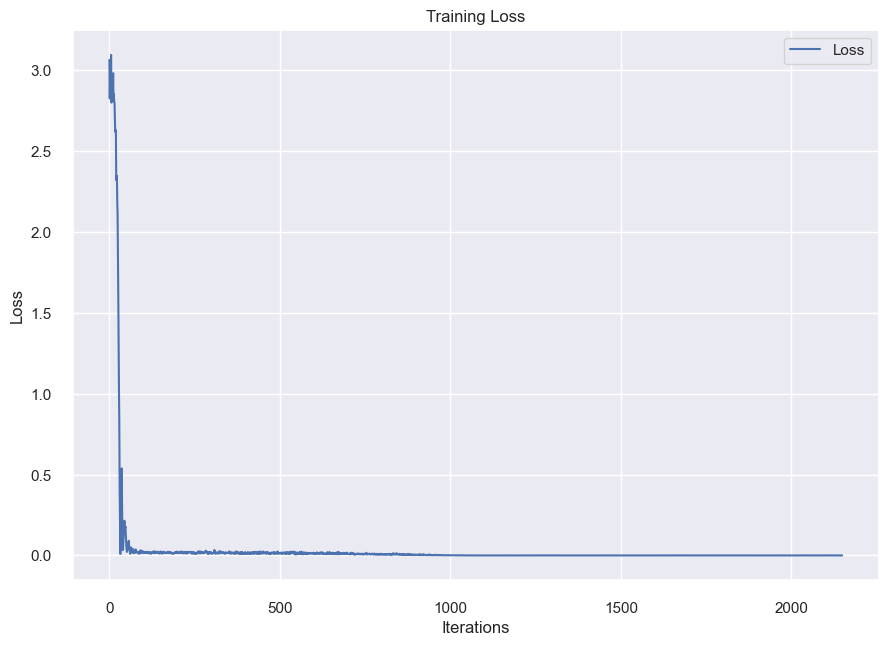

In [10]:
plt.figure()
plt.plot(loss_list, label="Loss")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()

模型评估


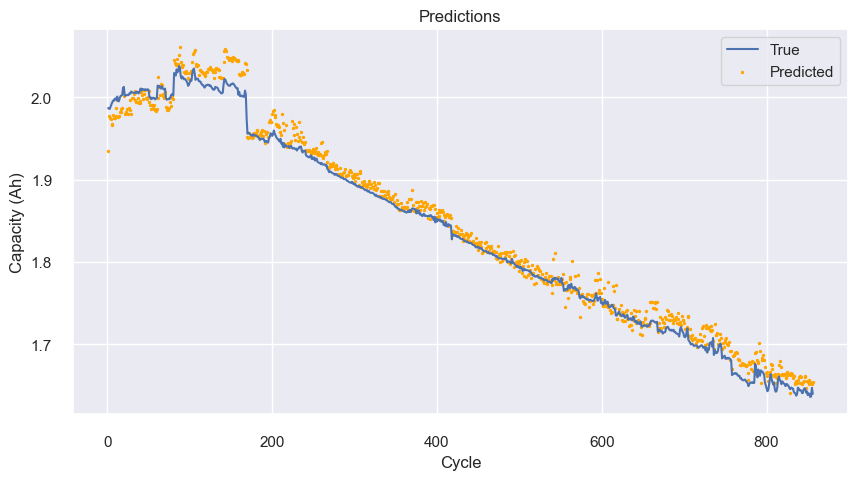

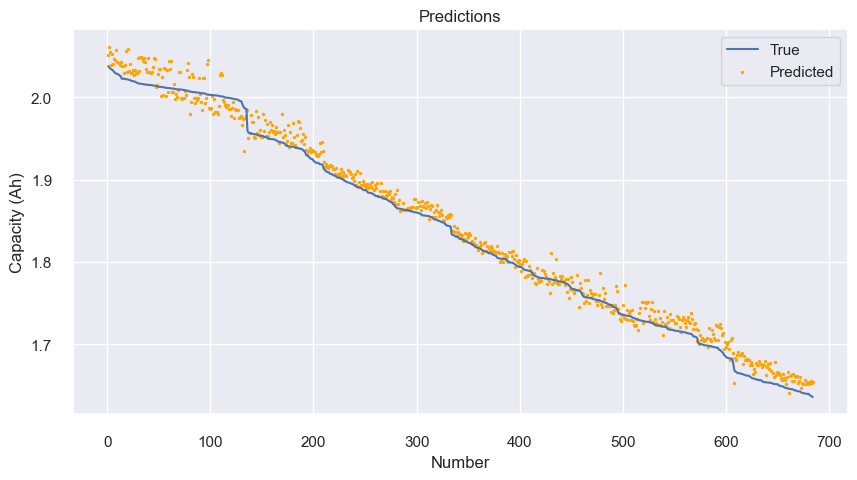

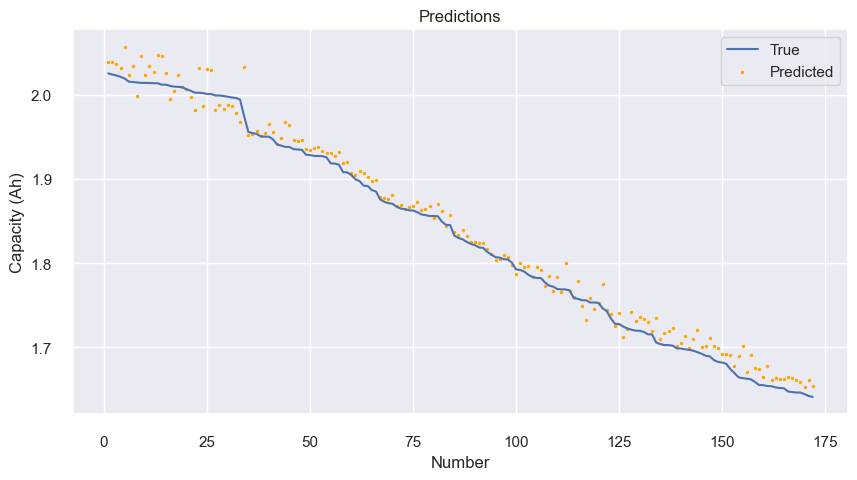

In [11]:
predictor.eval()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_predictions_X(predictor, X, y):
    with torch.no_grad():
        y_pred = predictor(X.float()).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y) + 1)), y, label="True")
    plt.scatter(
        list(range(1, len(y_pred) + 1)), y_pred, label="Predicted", color="orange", s=2
    )
    plt.title("Predictions")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.show()


def plot_predictions_dataloader(predictor, dataloader, device):
    y, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X.float())
            y.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())

    sorted_values = sorted(zip(y, y_pred), reverse=True)
    y, y_pred = zip(*sorted_values)
    
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, len(y)+1)), y, label="True")
    plt.scatter(list(range(1, len(y_pred)+1)), y_pred, label="Predicted", color="orange", s=2)
    plt.title("Predictions")
    plt.xlabel("Number")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.show()


plot_predictions_X(predictor, X, y)

plot_predictions_dataloader(predictor, train_dataloader, device)
plot_predictions_dataloader(predictor, val_dataloader, device)

In [12]:
# Metrics
from sklearn.metrics import root_mean_squared_error


def calculate_metrics(predictor, dataloader, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = predictor(batch_X)
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(output.cpu().numpy())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    rmse = root_mean_squared_error(y_true, y_pred)
    mre = np.mean(np.abs((y_true - y_pred) / y_true))
    return rmse, mre


rmse_train, mre_train = calculate_metrics(predictor, train_dataloader, device)

print("Training Metrics")
print(f"RMSE (Ah): {rmse_train:.4f}")
print(f"MRE: {mre_train:.4f}")

rmse_val, mre_val = calculate_metrics(predictor, val_dataloader, device)

print("Validation Metrics")
print(f"RMSE (Ah): {rmse_val:.4f}")
print(f"MRE: {mre_val:.4f}")

Training Metrics
RMSE: 0.0140
MRE: 0.0062
Validation Metrics
RMSE: 0.0149
MRE: 0.0065


保存模型


In [13]:
path = "./2.0A/battery_predictor-2A.pth"
torch.save(predictor.state_dict(), path)
print(f"模型已保存到 {path}")

模型已保存到 ./2.0A/battery_predictor-2A.pth
